This notebook aims to check the TROPOMI cloud pressure and tropopause pressure over lightning pixels.

In [1]:
import proplot as pplt
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
from matplotlib.ticker import PercentFormatter

## Read lightning pixel data

In [2]:
ds_swath_70 = xr.open_mfdataset('../data/swath_lightning_crf70*.nc', concat_dim='time', combine='nested')
ds_swath_70 = ds_swath_70.where(ds_swath_70['lightning_counts']>100)

## Check the percentage for each cloud pressure bin

In [3]:
bin_ptropo = np.arange(160, 280, 20)
# bin_pcld = np.arange(150, 650, 50)
# bin_pcld = np.arange(100, 650, 50)
bin_pcld = np.arange(100, 950, 50)
# bin_ptropo = np.arange(200, 350, 50)
# bin_pcld = np.arange(200, 350, 50)

ptropo_center = np.convolve(bin_ptropo, np.ones(2), 'valid') / 2
pcld_center = np.convolve(bin_pcld, np.ones(2), 'valid') / 2

# https://github.com/xgcm/xhistogram/issues/16#issuecomment-1167271530
hts = histogram(ds_swath_70['pcld'], ds_swath_70['ptropo'], bins=[bin_pcld, bin_ptropo], dim=['longitude', 'latitude']).sum(dim='time')

In [4]:
# total data counts in bins
ptropo_bin_counts = np.count_nonzero(~np.isnan(ds_swath_70['ptropo']))
pcld_bin_counts = np.count_nonzero(~np.isnan(ds_swath_70['pcld']))

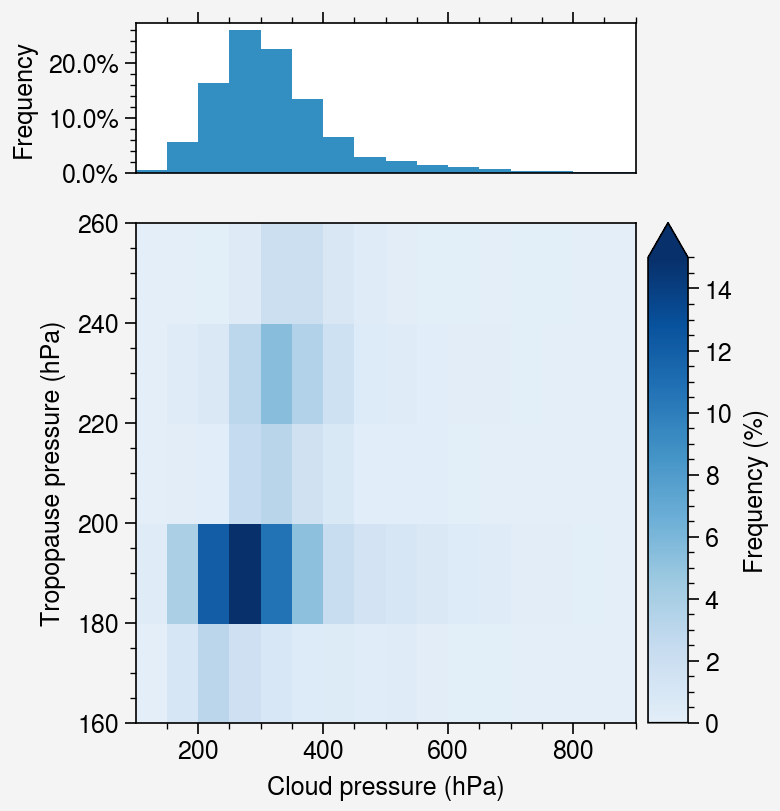

In [5]:
fig, axs = pplt.subplots()

(hts/ptropo_bin_counts*100).plot(x='pcld_bin', ax=axs, vmin=0, vmax=15, discrete=False, cmap='Blues',
                          cbar_kwargs=dict(label='Frequency (%)'),
                          cmap_kw={'left': 0.1})


ax = axs.panel(side='t', space=2, width='6em')
ds_swath_70['pcld'].plot.hist(ax=ax, bins=np.arange(100, 950, 50), weights=np.ones(pcld_bin_counts) / pcld_bin_counts, alpha = 0.8)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.format(grid=False, xlabel='Cloud pressure (hPa)', ylabel='Frequency', xlim=(100, 900))


axs.format(grid=False, ylabel='Tropopause pressure (hPa)', xlabel='Cloud pressure (hPa)')

fig.savefig('../figures/pcld_ptropo.png')